## Problem Statement

 Predict the taxi fare amount in New York city using Dask-ML.

### Dataset

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. Its variables are as follows:
![Dataset](https://cdn.iisc.talentsprint.com/CDS/Images/NYC_Taxi_data_description.png)




In [ ]:
#@title Install Dask dependencies and restart runtime
!pip -qq install dask-ml
!pip -qq install dask
!pip -qq install dask[complete]
!pip -qq install dask distributed
!pip -qq install mimesis

#### Importing Necessary Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import dask
import dask.dataframe as dd
import dask.array as da
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import mean_squared_error, r2_score
from dask.distributed import Client
import time as time
import numpy as np
import pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
%matplotlib inline

from dask.distributed import Client, progress
# client = Client()

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Dask_MP_dataset.csv

In [ ]:
%%time
ddf = dd.read_csv('/content/Dask_MP_dataset.csv', dtype={'passenger_count': 'int64'})

CPU times: user 34.4 ms, sys: 12 ms, total: 46.4 ms
Wall time: 164 ms


#### Use pandas to read the dataset and compare the time taken

In [ ]:
%%time
df_pd = pd.read_csv('/content/Dask_MP_dataset.csv')

CPU times: user 4.67 s, sys: 927 ms, total: 5.59 s
Wall time: 5.6 s


In [ ]:
%%time
ddf.head()

CPU times: user 1.62 s, sys: 313 ms, total: 1.94 s
Wall time: 1.93 s


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### Data Analysis

Drop those columns which are not useful in EDA as well as model implementation

In [ ]:
ddf = ddf.drop(["key", "Unnamed: 0"],axis=1)

In [ ]:
# Drop duplicate rows
%%time
ddf = ddf.drop_duplicates()

CPU times: user 9.76 ms, sys: 0 ns, total: 9.76 ms
Wall time: 11.2 ms


In [ ]:
# ddf['pickup_datetime'] = dask.dataframe.to_datetime(ddf['pickup_datetime'])
# ddf['year'] = ddf['pickup_datetime'].dt.year
# ddf.head()

In [ ]:
%%time
ddf = ddf.dropna()

CPU times: user 10.9 ms, sys: 995 µs, total: 11.9 ms
Wall time: 12 ms


In [ ]:
# Drop duplicate rows in pandas dataframe
%%time
df_pd = df_pd.drop_duplicates()

CPU times: user 5.62 s, sys: 136 ms, total: 5.76 s
Wall time: 7.22 s


In [ ]:
%%time
df_pd = df_pd.dropna()

CPU times: user 538 ms, sys: 10 ms, total: 548 ms
Wall time: 751 ms


In [ ]:
%%time
ddf.groupby("passenger_count").fare_amount.mean().compute()

CPU times: user 13.4 s, sys: 1.02 s, total: 14.4 s
Wall time: 18.2 s


passenger_count
0        8.862578
1       11.224834
2       11.819826
3       11.533967
4       11.747775
5       11.208924
6       12.158254
9      104.000000
208      3.300000
Name: fare_amount, dtype: float64

In [ ]:
%%time
df_pd.groupby("passenger_count").fare_amount.mean()

CPU times: user 52.4 ms, sys: 2.02 ms, total: 54.4 ms
Wall time: 111 ms


passenger_count
0        8.862578
1       11.224824
2       11.819826
3       11.533967
4       11.747775
5       11.208924
6       12.158254
9      104.000000
208      3.300000
Name: fare_amount, dtype: float64

In [ ]:
%%time
ddf[["fare_amount"]].mean().compute()

CPU times: user 10.9 s, sys: 586 ms, total: 11.5 s
Wall time: 10.2 s


fare_amount    11.347683
dtype: float64

In [ ]:
%%time
df_pd[["fare_amount"]].mean()

CPU times: user 14.2 ms, sys: 1.92 ms, total: 16.2 ms
Wall time: 17.2 ms


fare_amount    11.347676
dtype: float64

Visualize the target variable, i.e., `fare_amount` to study the fare distribution, using a histogram density plot. Analyze the fare_amount distribution, try to visualize it for a range of [0, 60].


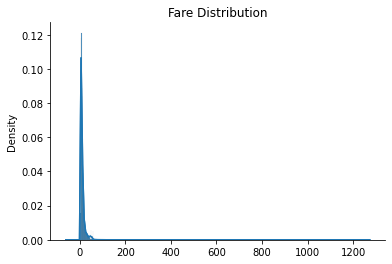

In [ ]:
#exploring data

def plot_dist(series=ddf["fare_amount"], title = "Fare Distribution"):
  sns.histplot(series, kde=True, stat='density',discrete=True)
  sns.despine()
  plt.title(title)
  sns.histplot(series, kde=True, stat='density',discrete=True)
  sns.despine()
  plt.title(title);
  plt.show();
  plt.show()
plot_dist()

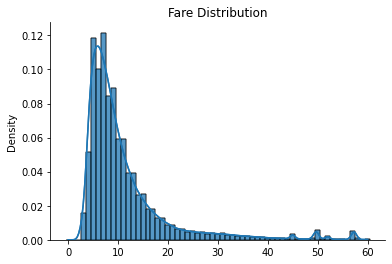

In [ ]:
#dropping absurd values and plotting fare amount in the range [0, 60]
ddf = ddf[ddf.fare_amount.between(0,60)]
plot_dist(ddf.fare_amount)

#### Observe the number of workers and cores running in your machine

Initialize a client and observe how many workers are working and the number of cores utilizing for the given data set.

In [ ]:
# #Initializing a client
# client = Client(processes=False)
# client

From, above you can observe how many workers are working and the number of cores utilizing for the given data set.

### EDA based on Time

Extract day of the week (dow), hour, month and year from `pickup_datetime`.

In [ ]:
# pickup_datetime feature

def extract_time_features(ddf):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    ddf.index = pd.to_datetime(ddf[time_column])
    #ddf.index = ddf.index.tz_convert(timezone_name)
    ddf["dow"] = ddf.index.weekday
    ddf["hour"] = ddf.index.hour
    ddf["month"] = ddf.index.month
    ddf["year"] = ddf.index.year
    return ddf.reset_index(drop=True)

In [ ]:
ddf = extract_time_features(ddf.compute())

In [ ]:
ddf.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,2010
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,2011
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2012
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,2010


Plot the taxi trip by hour of the day

In [ ]:
ddf = dd.from_pandas(ddf, npartitions=3)

In [ ]:
type(ddf)

dask.dataframe.core.DataFrame

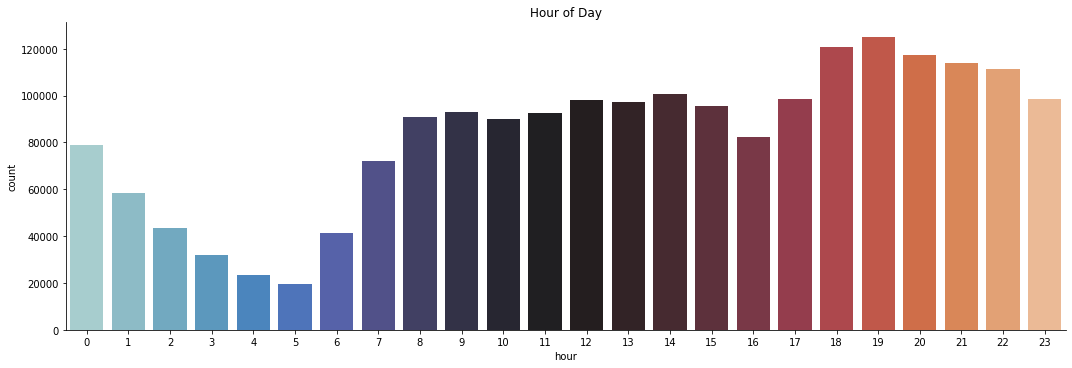

In [ ]:
# taxi trip repartition by hour of the day

sns.catplot(x="hour", kind="count", palette="icefire", data=ddf.compute(), height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

Plot the taxi trip repartition by day of the week (dow)

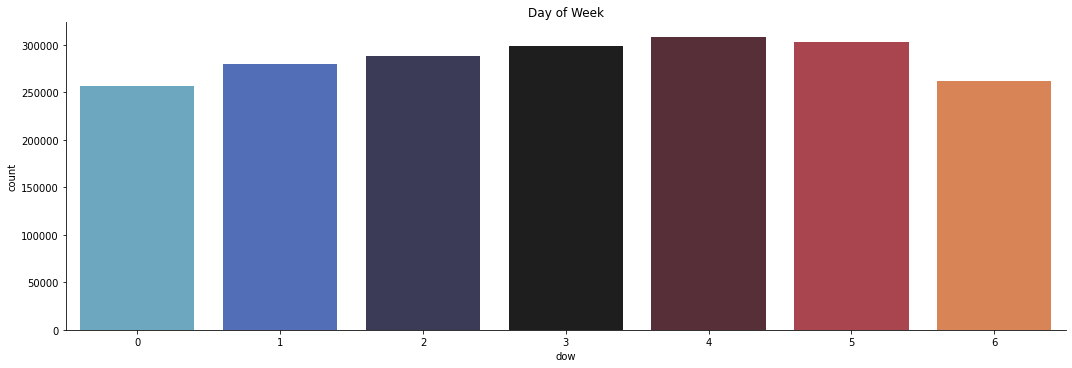

In [ ]:
# taxi trip repartition by day of the week

sns.catplot(x="dow", kind="count", palette="icefire", data=ddf.compute(), height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

Draw a plot between the target variable and passenger count and analyze it.

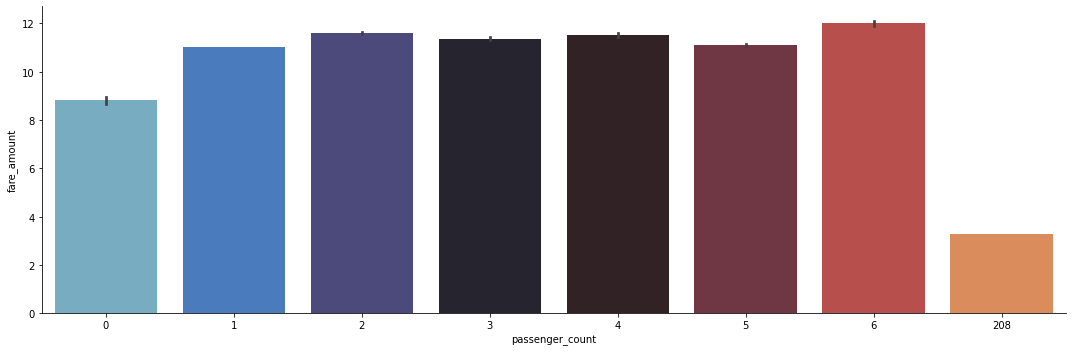

In [ ]:
#passenger count feature

sns.catplot(x="passenger_count", y="fare_amount", palette="icefire", data=ddf.compute(), kind="bar", aspect=3)
sns.despine()
plt.show()

Draw a plot between the target variable and hour and analyze it.

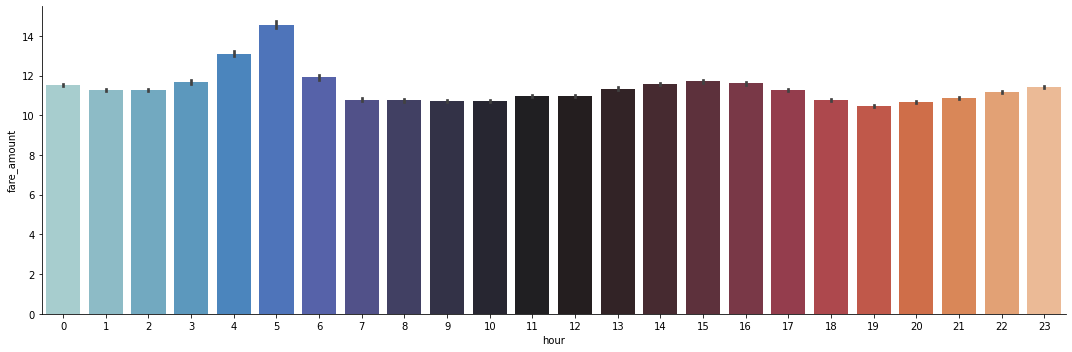

In [ ]:
#fare amount by hour

sns.catplot(x="hour", y="fare_amount", palette="icefire", data=ddf.compute(), kind="bar", aspect=3)
sns.despine()
plt.show()

Compute the Haversine distance between samples

* Convert the latitude and longitude co-rodinates to radians

* Calculate the Haversine distance

  **Hint:** [haversine_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html)

* Add the "distance" feature to the dataset and plot its distribution

In [ ]:
# Distance feature (given formula)

def haversine_distance(ddf,
                       start_lat="start_lat",
                       start_lon="start_lon",
                       end_lat="end_lat",
                       end_lon="end_lon"):

    # Calculate the great circle distance between two points
    #on the earth (specified in decimal degrees).

    # Vectorized version of the haversine distance for pandas df
    #Computes distance in kms

    lat_1_rad, lon_1_rad = np.radians(ddf[start_lat].astype(float)), np.radians(ddf[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(ddf[end_lat].astype(float)), np.radians(ddf[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance

In [ ]:
%%time
ddf["distance"] = haversine_distance(ddf,
                                     start_lat="pickup_latitude", start_lon="pickup_longitude",
                                     end_lat="dropoff_latitude", end_lon="dropoff_longitude"
                                     )

CPU times: user 25 ms, sys: 0 ns, total: 25 ms
Wall time: 30.2 ms


In [ ]:
ddf.distance.describe()

Dask Series Structure:
npartitions=1
    float64
        ...
Name: distance, dtype: float64
Dask Name: describe-numeric, 130 tasks

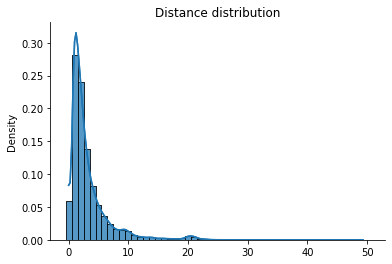

In [ ]:
%matplotlib inline
plot_dist(series=ddf[ddf.distance<50].distance, title = "Distance distribution")

### Correlation between distance and fare amount

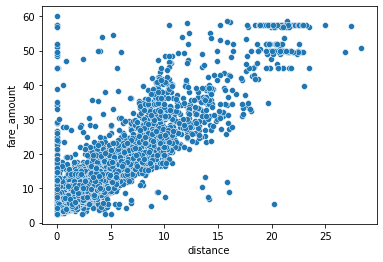

In [ ]:
# Correlation between fare_amount and distance

sns.scatterplot(x="distance", y="fare_amount", palette="icefire",data=ddf[ddf.distance < 80].compute().sample(10000))
plt.show()

### Preparing dataset for model implementation

In [ ]:
# Read the dataset to prepare for training

data_train = ddf

### Removing outliers from training set Based on Coordinates

Exercise 8: Remove the outliers using the given latitude and longitude features from the dataset. We need to analyze the data of taxi within New York City.

In [ ]:
%%time
data_train = data_train[data_train["pickup_latitude"].between(left = 40, right = 42 )]
data_train = data_train[data_train["pickup_longitude"].between(left = -74.3, right = -72.9 )]
data_train = data_train[data_train["dropoff_latitude"].between(left = 40, right = 42 )]
data_train = data_train[data_train["dropoff_longitude"].between(left = -74, right = -72.9 )]

CPU times: user 7.85 ms, sys: 7 µs, total: 7.85 ms
Wall time: 7.69 ms


In [ ]:
%%time
data_train["distance"] = haversine_distance(data_train,
                                      start_lat="pickup_latitude", start_lon="pickup_longitude",
                                      end_lat="dropoff_latitude", end_lon="dropoff_longitude"
                                     )

CPU times: user 27 ms, sys: 917 µs, total: 27.9 ms
Wall time: 28.3 ms


In [ ]:
data_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dow,hour,month,year,distance
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0,17,6,2009,1.030764
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,1,16,1,2010,8.450134
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,3,0,8,2011,1.389525
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,5,4,4,2012,2.799270
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1,7,3,2010,1.999157


Divide the data into train and test splits with X as feature variables and y as target variable

In [ ]:
X = data_train.drop(["fare_amount", "pickup_datetime"], axis=1)
y = data_train[["fare_amount"]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
type(X_train)

dask.dataframe.core.DataFrame

In [ ]:
type(y_train)

dask.dataframe.core.DataFrame

In [ ]:
X_train = X_train.compute()

In [ ]:
y_train = y_train.compute()

In [ ]:
#fit the model
lr = LinearRegression()

In [ ]:
%%time
lr.fit(X_train.values, y_train.values)

CPU times: user 7.22 s, sys: 1.26 s, total: 8.48 s
Wall time: 4.51 s


LinearRegression()

Predict the test data and calculate the mean squared error and r2 score.

In [ ]:
%%time
X_test = X_test.compute()
y_pred = lr.predict(X_test.values)

CPU times: user 1.62 s, sys: 190 ms, total: 1.81 s
Wall time: 1.4 s


In [ ]:
y_pred

array([19.00381576,  6.43512157,  7.05163524, ..., 11.28973319,
       11.10232171, 13.76304815])

In [ ]:
y_test = y_test.to_dask_array(lengths=True)


In [ ]:
y_test = y_test.reshape(-1)

In [ ]:
y_test.compute()

array([16.9,  5.7,  5.3, ..., 10.5, 10.9, 12.9])

In [ ]:
# Mean squared error
%%time
mean_squared_error(y_test, y_pred)

CPU times: user 1.47 s, sys: 74.2 ms, total: 1.55 s
Wall time: 1.16 s


20.58352710235977

In [ ]:
# R2_Score
%%time
r2_score(y_test, y_pred)

CPU times: user 1.5 s, sys: 95.7 ms, total: 1.6 s
Wall time: 1.25 s


0.7460908308122315